To fit the data to the specified equations, `fit_data` is a function with three arguments:

1. `filename`: Specifies the CSV file containing the data for fitting.
2. `use_log`: When set to `True`, the function fits the data on a logarithmic scale. By default, it is set to `False`, meaning the data will be fitted using its original scale.
3. `fit_eqs`: Determines which equation the data should be fitted to. The default option is 'both', but you can also select 'eq1' or 'eq2'.

The equations are as follows:

\
\begin{aligned}
&\frac{F}{F_0}=\frac{1+F_1 / F_0 k_1\left[CD_0\right]+F_2 / F_0 k_1 k_2\left[CD_0\right]^2}{\left(1+k_1\left[C D_0\right]+k_1 k_2\left[C D_0\right]^2\right)}\;\text{(eq.1)}
\\\\
&\frac{F}{F_0}=\frac{1+F_1 / F_0 k_1\left[CD_0\right]}{\left(1+k_1\left[CD_0\right]\right)}\;\text{(eq.2)}
\end{aligned}


## 0. Uploading the data

In [ ]:
from google.colab import files
uploaded = files.upload()

## 1. Importing python libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

## 2. fit_data, eq1 and eq2 functions

In [ ]:
def fit_data(filename, use_log=False, fit_eqs='both', average_data=False):

    base_filename = filename.replace(".csv", "")
    log_str = "log" if use_log else "no_log"
    avg_str = "avg" if average_data else "no_avg"
    filename_suffix = f"{base_filename}_{log_str}_{avg_str}_eq_{fit_eqs}"

    if not os.path.exists('plots'):
        os.mkdir('plots')
    if not os.path.exists('results'):
        os.mkdir('results')

    data = pd.read_csv(filename)
    CD0 = data["CD0"].values

    if use_log:
        with np.errstate(divide='ignore', invalid='ignore'):
            CD0 = np.where(CD0 > 0, np.log10(CD0), 0)

    FF0_cols = [col for col in data.columns if "F/F0" in col]
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'grey']

    plt.figure(figsize=(10, 6))

    initial_guess1 = [1, 1, 1, 1]
    initial_guess2 = [1, 1]

    results_df_eq1 = pd.DataFrame()
    results_df_eq2 = pd.DataFrame()

    r2_scores_eq1 = []
    r2_scores_eq2 = []

    param_mapping_eq1 = {0: 'F1', 1: 'F2', 2: 'k1', 3: 'k2'}
    param_mapping_eq2 = {0: 'F1', 1: 'k1'}

    if average_data:
        run_names = ['Averaged_Data']
    else:
        run_names = [f'Run_{i+1}' for i in range(len(FF0_cols))]

    # Plot original data points from all runs
    for idx, FF0_col in enumerate(FF0_cols):
        F_over_F0 = data[FF0_col].values
        if use_log:
            with np.errstate(divide='ignore', invalid='ignore'):
                F_over_F0 = np.where(F_over_F0 > 0, np.log10(F_over_F0), 0)
        plt.scatter(CD0, F_over_F0, color=colors[idx % len(colors)], label=f'Data ({FF0_col})', alpha=0.6)

    if average_data:
        F_over_F0_mean = data[FF0_cols].mean(axis=1).values
        F_over_F0_std = data[FF0_cols].std(axis=1).values

        if use_log:
            # Apply error propagation for log transformation
            with np.errstate(divide='ignore', invalid='ignore'):
                F_over_F0_std = F_over_F0_std / (F_over_F0_mean * np.log(10))
                F_over_F0_std = np.nan_to_num(F_over_F0_std, nan=0.0, posinf=0.0, neginf=0.0)
                F_over_F0_mean = np.where(F_over_F0_mean > 0, np.log10(F_over_F0_mean), 0)

        # Plot averaged data points with error bars
        plt.errorbar(CD0, F_over_F0_mean, yerr=F_over_F0_std, fmt='o', color='brown',
                     ecolor='brown', elinewidth=1, capsize=3, label='Averaged Data', markersize=8)

        # Perform fitting on averaged data
        if fit_eqs == 'both' or fit_eqs == 'eq1':
            params1, _ = curve_fit(eq1, CD0, F_over_F0_mean, p0=initial_guess1, maxfev=10000)
            for i, param in enumerate(params1):
                results_df_eq1.at[param_mapping_eq1[i], run_names[0]] = param
            y_pred1 = eq1(CD0, *params1)
            r2_eq1 = r2_score(F_over_F0_mean, y_pred1)
            r2_scores_eq1.append(r2_eq1)
            plt.plot(CD0, y_pred1, label='FitAveraged Data)', linestyle='dashed', color='brown')

        if fit_eqs == 'both' or fit_eqs == 'eq2':
            params2, _ = curve_fit(eq2, CD0, F_over_F0_mean, p0=initial_guess2, maxfev=10000)
            for i, param in enumerate(params2):
                results_df_eq2.at[param_mapping_eq2[i], run_names[0]] = param
            y_pred2 = eq2(CD0, *params2)
            r2_eq2 = r2_score(F_over_F0_mean, y_pred2)
            r2_scores_eq2.append(r2_eq2)
            plt.plot(CD0, y_pred2, label='Fitted Averaged Data', linestyle='dotted', color='brown')

    else:
        for idx, FF0_col in enumerate(FF0_cols):
            F_over_F0 = data[FF0_col].values
            if use_log:
                with np.errstate(divide='ignore', invalid='ignore'):
                    F_over_F0 = np.where(F_over_F0 > 0, np.log10(F_over_F0), 0)

            if fit_eqs == 'both' or fit_eqs == 'eq1':
                params1, _ = curve_fit(eq1, CD0, F_over_F0, p0=initial_guess1, maxfev=10000)
                for i, param in enumerate(params1):
                    results_df_eq1.at[param_mapping_eq1[i], run_names[idx]] = param
                y_pred1 = eq1(CD0, *params1)
                r2_eq1 = r2_score(F_over_F0, y_pred1)
                r2_scores_eq1.append(r2_eq1)
                plt.plot(CD0, y_pred1, label=f'Fit Eq 1 ({FF0_col})', linestyle='dashed', color=colors[idx])

            if fit_eqs == 'both' or fit_eqs == 'eq2':
                params2, _ = curve_fit(eq2, CD0, F_over_F0, p0=initial_guess2, maxfev=10000)
                for i, param in enumerate(params2):
                    results_df_eq2.at[param_mapping_eq2[i], run_names[idx]] = param
                y_pred2 = eq2(CD0, *params2)
                r2_eq2 = r2_score(F_over_F0, y_pred2)
                r2_scores_eq2.append(r2_eq2)
                plt.plot(CD0, y_pred2, label=f'Fit Eq 2 ({FF0_col})', linestyle='dotted', color=colors[idx])

            plt.scatter(CD0, F_over_F0, color=colors[idx], label=f'Data ({FF0_col})')

    # plt.title(f"{base_filename} data fitted with equeation 2")
    plt.xlabel(r'$CD_0$ (log)' if use_log else r'$CD_0$')
    plt.ylabel(r'$F/F_0$ (log)' if use_log else r'$F/F_0$')
    plt.legend(loc='lower right')  # Place the legend in the lower right corner
    plt.savefig(os.path.join('plots', filename_suffix + "_plot.png"), dpi=300)
    plt.show()

    if r2_scores_eq1:
        r2_df_eq1 = pd.DataFrame({'R^2': r2_scores_eq1}).T
        r2_df_eq1.columns = run_names
        r2_df_eq1.index = ['R^2']
        results_df_eq1 = pd.concat([results_df_eq1, r2_df_eq1])

    if r2_scores_eq2:
        r2_df_eq2 = pd.DataFrame({'R^2': r2_scores_eq2}).T
        r2_df_eq2.columns = run_names
        r2_df_eq2.index = ['R^2']
        results_df_eq2 = pd.concat([results_df_eq2, r2_df_eq2])

    combined_results = pd.concat([results_df_eq1, results_df_eq2], keys=['Eq1', 'Eq2'])
    combined_results.reset_index(inplace=True)
    combined_results.rename(columns={'level_0': 'Equation', 'level_1': 'Parameter'}, inplace=True)

    # Only add 'Average' column when not averaging data
    if not average_data:
        combined_results['Average'] = combined_results[run_names].mean(axis=1)

    combined_results.to_csv(os.path.join('results', filename_suffix + "_results.csv"), index=False)
    return combined_results

def eq1(CD0, F1, F2, k1, k2):
    F0 = 1.0
    num = 1 + F1 / F0 * k1 * CD0 + F2 / F0 * k1 * k2 * CD0 ** 2
    den = 1 + k1 * CD0 + k1 * k2 * CD0 ** 2
    return num / den

def eq2(CD0, F1, k1):
    F0 = 1.0
    num = 1 + F1 / F0 * k1 * CD0
    den = 1 + k1 * CD0
    return num / den


## Fitting the equation

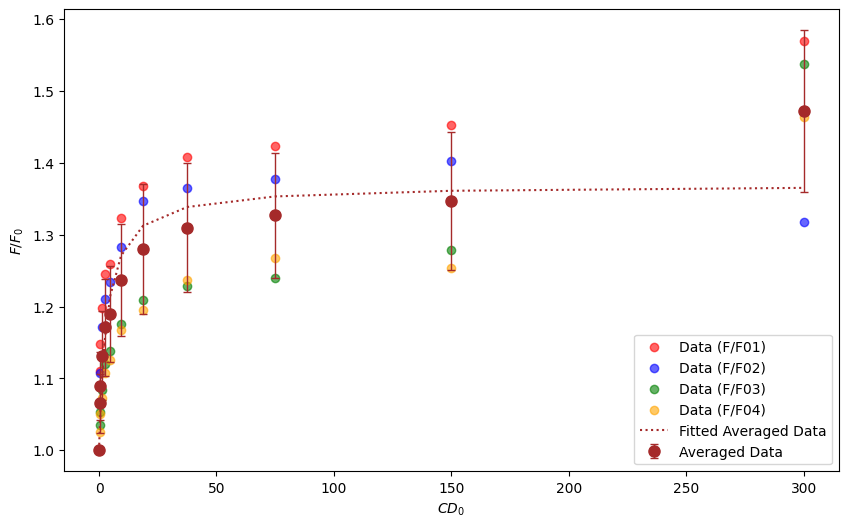

,Equation,Parameter,Averaged_Data
0,Eq2,F1,1.369277
1,Eq2,k1,0.293245
2,Eq2,R^2,0.899965


In [ ]:
fit_data("Lan - HPBCD 275 B.csv", use_log=False, fit_eqs='eq2', average_data=True)

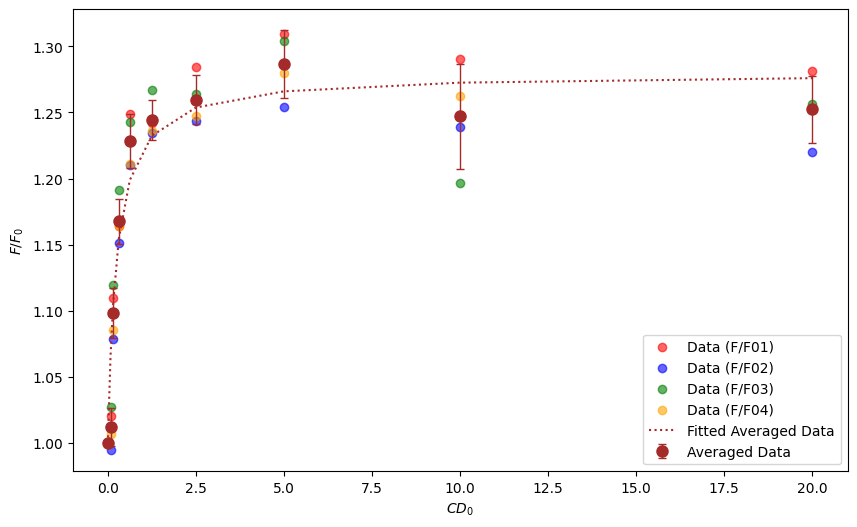

,Equation,Parameter,Averaged_Data
0,Eq2,F1,1.279482
1,Eq2,k1,3.945627
2,Eq2,R^2,0.942654


In [ ]:
fit_data("Lan - Captisol 275.csv", use_log=False, fit_eqs='eq2', average_data=True)

In [ ]:
!rm -rf plots